# Decision Tree Regressor

## Imports

In [49]:
from ta import *
import pandas, numpy as np
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [9]:
## Read Data
def readDEX(filepath):
    rawData = pandas.read_csv(filepath).replace('.', np.nan).fillna(method='ffill')
    # TODO : Parse dates
    rawData.VALUE = rawData.VALUE.astype(float)
    return rawData

In [11]:
usCa = readDEX('data/DEXCAUS.csv')

### Output Column

In [276]:
others.daily_return(usCa['VALUE'])[:10]

0         NaN
1   -0.069245
2    0.039596
3    0.415595
4    0.059125
5    0.049242
6   -0.285461
7   -0.078973
8    0.108674
9    0.019737
Name: d_ret, dtype: float64

# Building Strategies

In [277]:
usCa['dpo'] = trend.dpo(usCa['VALUE'])
usCa['macd'] = trend.macd(usCa['VALUE'])
usCa['macd_signal'] = trend.macd_signal(usCa['VALUE'])
usCa['macd_diff'] = trend.macd_diff(usCa['VALUE'])
usCa['tsi'] = momentum.tsi(usCa['VALUE'])
usCa['rsi'] = momentum.rsi(usCa['VALUE'])
usCa['trix'] = trend.trix(usCa['VALUE'])
usCa['hband'] = volatility.bollinger_hband(usCa['VALUE'])
usCa['lband'] = volatility.bollinger_lband(usCa['VALUE'])

# Output column
usCa['return'] = others.daily_return(usCa['VALUE'])
usCa['gained'] = usCa['return'] > 0
usCa[:10]

,DATE,VALUE,dpo,macd_signal,return,tsi,rsi,gained,trix,macd_diff,macd,hband,lband,donchain,hdonchain,ldonchain
0,1971-01-04,1.0109,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,1971-01-05,1.0102,NaN,NaN,-0.069245,-100.000000,NaN,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2,1971-01-06,1.0106,NaN,NaN,0.039596,-65.929566,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,1971-01-07,1.0148,NaN,NaN,0.415595,21.592445,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,1971-01-08,1.0154,NaN,NaN,0.059125,41.553943,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
5,1971-01-11,1.0159,NaN,NaN,0.049242,50.969532,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
6,1971-01-12,1.0130,NaN,NaN,-0.285461,43.100626,NaN,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
7,1971-01-13,1.0122,NaN,NaN,-0.078973,36.308132,NaN,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
8,1971-01-14,1.0133,NaN,NaN,0.108674,33.336623,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
9,1971-01-15,1.0135,NaN,NaN,0.019737,31.539850,NaN,True,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [79]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [232]:
inputCols = ['VALUE', 'dpo', 'macd', 'macd_signal', 'macd_diff', 'tsi', 'rsi', 'trix', 'hband', 'lband']
outputCols = ['return']

## Slice at 25 because that's the last index of a NaN value
## Shift outputs by 1 day forward
offset = 25
inputs = usCa[inputCols][offset:-1]
outputs = usCa[outputCols][offset+1:]

In [145]:
clf = DecisionTreeRegressor(random_state=0)
cross_val_score(clf, inputs, outputs, cv=10)

array([-10.84579612,  -3.03865406,  -2.19333913,  -1.84816799,
        -1.5441984 ,  -1.75119023,  -4.31991314,  -0.7252527 ,
        -1.22998258,  -1.07868335])

In [157]:
clf.fit(inputs, outputs)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [158]:
# Feature importances
srt = sorted(list(zip(inputCols, clf.feature_importances_)), key=lambda x: x[1])
srt.reverse()
srt

[('dpo', 0.1749766178874021),
 ('macd_diff', 0.12667752368642093),
 ('rsi', 0.11984081958107358),
 ('tsi', 0.11015869022268132),
 ('trix', 0.10555126314724007),
 ('macd', 0.09309440803367552),
 ('macd_signal', 0.08299413503953483),
 ('hband', 0.07000429894812481),
 ('lband', 0.06513205099744934),
 ('VALUE', 0.05157019245639747)]

## Make Trades

In [113]:
predictions = clf.predict(inputs)

In [114]:
pd.Series(predictions).describe()

count    12409.000000
mean         0.002902
std          0.402447
min         -4.945140
25%         -0.165180
50%          0.000000
75%          0.164730
max          3.880356
dtype: float64

In [115]:
# Place trades on top 75% and sell when falls below 50%
buyThreshold = 0.164730
sellThreshold = 0.00
buys = predictions > buyThreshold
sells = predictions < sellThreshold

In [117]:
buys

array([False, False, False, ..., False,  True,  True])

In [118]:
buyInds = [i for i, x in enumerate(buys) if x == True]
sellInds = [i for i, x in enumerate(sells) if x == True]

In [135]:
# For each buy position find the next sell position
nextSellInd = []
tmp = np.array(sellInds)
for ind in buyInds:
    vals = np.where(tmp > ind)[0]
    if len(vals):
        indOfNextSell = tmp[vals[0]]
        nextSellInd.append(indOfNextSell)

In [278]:
positions = list(zip(buyInds, nextSellInd))
positions[:10]

[(11, 12),
 (80, 83),
 (82, 83),
 (85, 89),
 (87, 89),
 (94, 96),
 (119, 122),
 (120, 122),
 (128, 129),
 (130, 132)]

In [292]:
pd.Series(list(map(lambda a : a[1] - a[0], positions))).describe()

count    3101.000000
mean        2.091583
std         1.458677
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        11.000000
dtype: float64

In [262]:
enters = [a[0]+offset for a in positions]
exits = [a[1]+offset for a in positions]

In [279]:
# Positions of buys
usCa.loc[enters][:10]

,DATE,VALUE,dpo,macd_signal,return,tsi,rsi,gained,trix,macd_diff,macd,hband,lband,donchain,hdonchain,ldonchain
36,1971-02-23,1.0035,0.000420,-0.001518,-0.079657,-14.261394,13.388719,False,-0.015595,-0.000223,-0.001741,1.010938,1.004822,0.0,1.0101,1.0035
105,1971-05-31,1.0101,0.000120,0.000368,0.000000,5.958453,69.951436,False,0.005377,0.000081,0.000449,1.010426,1.007134,1.0,1.0101,1.0069
107,1971-06-02,1.0134,-0.000360,0.000529,0.079005,9.836610,87.879670,True,0.007388,0.000393,0.000922,1.012242,1.006278,1.0,1.0134,1.0069
110,1971-06-07,1.0161,-0.001525,0.001163,-0.127777,18.614899,71.615636,False,0.015684,0.000846,0.002009,1.017016,1.004434,0.0,1.0185,1.0083
112,1971-06-09,1.0186,-0.002615,0.001597,0.068769,22.820015,78.542442,True,0.021778,0.000869,0.002466,1.019263,1.004167,1.0,1.0186,1.0086
119,1971-06-18,1.0225,0.001620,0.003384,-0.165983,36.727359,64.368499,False,0.048019,0.000558,0.003941,1.029204,1.004556,0.0,1.0248,1.0086
144,1971-07-23,1.0151,0.001045,0.000688,-0.235872,21.746195,7.570305,False,0.010344,-0.001099,-0.000411,1.026294,1.017616,0.0,1.0235,1.0151
145,1971-07-26,1.0176,0.001270,0.000430,0.246281,19.543567,33.183783,True,0.006666,-0.001032,-0.000603,1.026484,1.016976,0.0,1.0235,1.0151
153,1971-08-05,1.0168,-0.000330,-0.000331,-0.166912,10.241826,33.692712,False,-0.006067,-0.000372,-0.000703,1.025163,1.015497,0.0,1.0231,1.0151
155,1971-08-09,1.0063,-0.004170,-0.000660,-1.207540,4.443544,18.834869,False,-0.010482,-0.001019,-0.001679,1.026858,1.011682,0.0,1.0231,1.0063


In [280]:
# Positions of sells
usCa.loc[exits][:10]

,DATE,VALUE,dpo,macd_signal,return,tsi,rsi,gained,trix,macd_diff,macd,hband,lband,donchain,hdonchain,ldonchain
37,1971-02-24,1.0075,0.000550,-0.001529,0.398605,-13.994300,52.751027,True,-0.016201,-0.000044,-0.001572,1.010627,1.004873,0.0,1.0090,1.0035
108,1971-06-03,1.0185,-0.000315,0.000724,0.503256,14.023445,94.449092,True,0.009856,0.000781,0.001506,1.014799,1.004831,1.0,1.0185,1.0069
108,1971-06-03,1.0185,-0.000315,0.000724,0.503256,14.023445,94.449092,True,0.009856,0.000781,0.001506,1.014799,1.004831,1.0,1.0185,1.0069
114,1971-06-11,1.0239,-0.003915,0.002195,0.000000,29.323051,87.076425,False,0.030093,0.001244,0.003439,1.023543,1.002887,1.0,1.0239,1.0086
114,1971-06-11,1.0239,-0.003915,0.002195,0.000000,29.323051,87.076425,False,0.030093,0.001244,0.003439,1.023543,1.002887,1.0,1.0239,1.0086
121,1971-06-22,1.0243,-0.002300,0.003562,0.009764,37.840999,70.943293,True,0.051358,0.000292,0.003854,1.030199,1.006601,0.0,1.0248,1.0086
147,1971-07-28,1.0221,0.001565,0.000130,0.156786,17.980281,58.422422,True,0.001840,-0.000442,-0.000312,1.026203,1.016867,0.0,1.0233,1.0151
147,1971-07-28,1.0221,0.001565,0.000130,0.156786,17.980281,58.422422,True,0.001840,-0.000442,-0.000312,1.026203,1.016867,0.0,1.0233,1.0151
154,1971-08-06,1.0186,-0.002610,-0.000406,0.177026,9.278005,45.678142,True,-0.007209,-0.000299,-0.000704,1.024830,1.015390,0.0,1.0231,1.0151
157,1971-08-11,1.0143,0.002180,-0.001116,0.148104,0.988931,44.168184,True,-0.016636,-0.000825,-0.001940,1.026180,1.010460,0.0,1.0228,1.0063


In [281]:
gains = list(map(lambda pos : usCa['VALUE'][pos[1]+offset]-usCa['VALUE'][pos[0]+offset], positions))
gains[:10]

[0.0040000000000000036,
 0.008399999999999963,
 0.005099999999999882,
 0.007800000000000029,
 0.005300000000000082,
 0.0018000000000000238,
 0.007000000000000117,
 0.0044999999999999485,
 0.0018000000000000238,
 0.008000000000000007]

In [285]:
pd.Series(gains).describe()

count    3101.000000
mean        0.009970
std         0.010509
min         0.001700
25%         0.004000
50%         0.006800
75%         0.012300
max         0.154800
dtype: float64

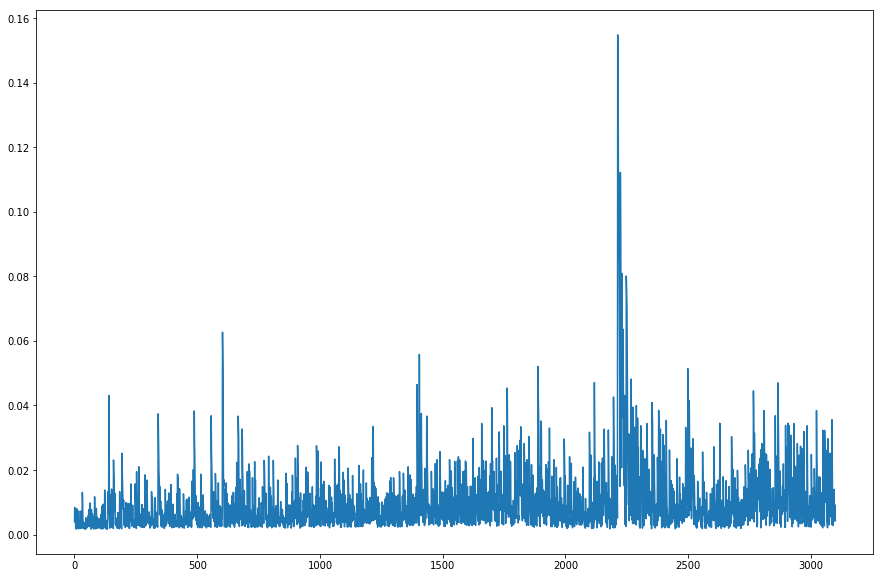

In [288]:
plt.plot(gains)

In [275]:
print('Sum of percentage gains :', sum(gains))
print('Compounded gains : ', np.prod(np.add(gains, 1.0)))

Sum of percentage gains : 30.91589999999997
Compounded gains :  19477772953236.383
